# RMSProp

* Deep Learning 299page - Ian Goodfellow, Yoshua Bengio, and Aaron Courville 참고

RMSProp 알고리즘은 AdaGrad의 gradient accumulation을 exponentially weighted moving average로 변경하여, non-convex 환경에서 더 좋은 performance를 보이도록 수정을 한 알고리즘입니다. (AdaGrad의 경우 convex function에서 빠르게 converge되도록 설계 되어 있습니다.) AdaGrad를 non-convex function에 적용한 경우, learning trajectory는 여러 구조(structure)를 거치다가 궁극적으로 locally convex bowl (local minimum)에 갖히게 되는 현상을 겪을수 있습니다. 이유인즉 AdaGrad의 경우 learning rate가 점차 줄어드는 현상때문입니다. 이때문에 막판에 작은 local minimum에 도달하지만, learning rate가 너무 작아 극복하지 못하고 갖혀버리게 됩니다. 

RMSProp의 경우 exponentially decaying average를 사용하여 local minimum에 걸려드는 단점을 극복합니다.(따라서 AdaGrad보다 non-convex에 강함) 

### 개인적인 실험 결과 

AdaDelta의 경우 엄청나게 많은 학습시간이 걸림.. <br>
반면에 RMSProp의 경우 매우 빠르게 학습됨. computation에서도 더 좋고, 더 빠르고, 그냥 다 좋음

### Algorithm

실제 알고리즘은.. AdaDelta와 동일하지만, Update를 계산할때.. 분모부분만 다릅니다. 

**Require:** global learning rate $ \eta $, decay rate $ \gamma $, Epsilon $ \epsilon $ (보통 $ 10^{-8}) $

#### Pseudo Code

1. Initialize accumulation variables $ E[g^2] = 0 $ 
  1. Compute Gradient $ g_t $
  2. Accumulate squared gradient: $$ E[g^2]_t = \gamma E[g^2]_{t-1} + (1-\gamma) \odot g^2_t $$
  3. Compute Update: $$ \Delta \theta_t = - \frac{\eta}{\sqrt{\epsilon + E[g^2]_t}} \odot g^2_t $$
  4. Apply Update: $$ \theta_{t + 1} = \theta_t + \Delta \theta_t $$

# Implementation 

### Import

In [1]:
%pylab inline
import numpy as np
import pandas as pd

from sklearn.model_selection import  train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_iris

Populating the interactive namespace from numpy and matplotlib


### Data

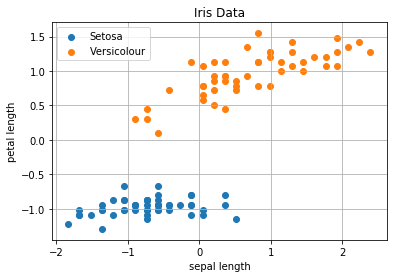

In [2]:
iris = load_iris()

# setosa_x = iris.data[:50]
# setosa_y = iris.target[:50]
# versicolor_x = iris.data[50:100]
# versicolor_y = iris.target[50:100]
# scatter(setosa_x[:, 0], setosa_x[:, 2])
# scatter(versicolor_x[:, 0], versicolor_x[:, 2])

# Extract sepal length, petal length from Setosa and Versicolor
data = iris.data[:100, [0, 2]]

# Standardization
scaler = StandardScaler()
data = scaler.fit_transform(data)


# Split data to test and train data
train_x, test_x, train_y, test_y = train_test_split(data, iris.target[:100], test_size=0.3)

# Plotting data
scatter(data[:50, 0], data[:50, 1], label='Setosa')
scatter(data[50:100, 0], data[50:100, 1], label='Versicolour')
title('Iris Data')
xlabel('sepal length')
ylabel('petal length')
grid()
legend()

In [22]:
w =   np.array([ 0.09370901, -0.24480254, -0.84210235]) # np.random.randn(2 + 1)

def predict(w, x):
    N = len(x)
    yhat = w[1:].dot(x.T) + w[0]
    return yhat

def rmsprop_nn(w, X, Y, eta=0.001, decay=0.001, epoch=4, weight_size=2):
    """
    @param eta <float>: learning rate
    """
    N = len(X)
    e = 1e-8
    
    Eg = np.zeros(weight_size + 1)  # E[g^2]
        
    for i in range(N):
        x = X[i]
        y = Y[i]
        x = x.reshape((-1, 2))
        yhat = predict(w, x)

        # Calculate the gradients
        gradient_w = 2/N*-(y-yhat).dot(x)
        gradient_b = 2/N*-(y-yhat)

        # Accumulate Gradient
        Eg[1:] = decay * Eg[1:] + (1-decay) * gradient_w**2
        Eg[0]  = decay * Eg[0] + (1-decay) * gradient_b**2

        # Compute Update
        delta_w = - eta/np.sqrt(e + Eg[1:]) * gradient_w
        delta_b = - eta/np.sqrt(e + Eg[0]) * gradient_b

        w[1:] = w[1:] + delta_w
        w[0] = w[0] + delta_b

    return w


for i in range(90):
    w = rmsprop_nn(w, train_x, train_y)

    # Accuracy Test
    yhats = predict(w, test_x)
    yhats = np.where(yhats >= 0.5, 1, 0)
    accuracy = round(accuracy_score(test_y, yhats), 2)
    print(f'[{i:2}] Accuracy: {accuracy:<4.2}, weights: {w}')

[ 0] Accuracy: 0.0 , weights: [ 0.09373244 -0.18564254 -0.77241726]
[ 1] Accuracy: 0.0 , weights: [ 0.09376026 -0.12642994 -0.70269564]
[ 2] Accuracy: 0.0 , weights: [ 0.09379347 -0.06715787 -0.63294029]
[ 3] Accuracy: 0.03, weights: [ 0.09383384 -0.00781901 -0.56315534]
[ 4] Accuracy: 0.07, weights: [ 0.0938846   0.0515939  -0.49334711]
[ 5] Accuracy: 0.4 , weights: [ 0.09395245  0.11108593 -0.42352611]
[ 6] Accuracy: 0.47, weights: [ 0.09405463  0.17065225 -0.3537144 ]
[ 7] Accuracy: 0.47, weights: [ 0.09426706  0.23023965 -0.28399464]
[ 8] Accuracy: 0.47, weights: [ 0.10417084  0.28000859 -0.22388516]
[ 9] Accuracy: 0.57, weights: [ 0.12370124  0.32053126 -0.17345896]
[10] Accuracy: 0.6 , weights: [ 0.1499493   0.3529442  -0.13009399]
[11] Accuracy: 0.7 , weights: [ 0.18192108  0.38015574 -0.09233826]
[12] Accuracy: 0.73, weights: [ 0.21830744  0.40297524 -0.05901621]
[13] Accuracy: 0.7 , weights: [ 0.25135654  0.42085854 -0.03066104]
[14] Accuracy: 0.7 , weights: [ 0.27701156  0.43